## Seasonally Adjust a Time Series Dataset


@Author: DJ Rajdev  
@Purpose: deseaon code for TS    
@Ref: https://anomaly.io/detect-seasonality-using-fourier-transform-r/index.html

**Why Seasonally Adjust Data ?**

Many industries experience fluctuations in various metrics based on the time of year. This means that it is not possible to effectively assess performance by comparing data from one time of year to data from another. Furthermore, these seasonal fluctuations can sometimes be so large that they can mask important business trends hiding in the data.

#### Setup

In [2]:
import pandas as pd
import numpy as np
#import plotnine
#from plotnine import *
import platform
import scipy as sc
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
import os
import matplotlib.pyplot as plt 

In [3]:
print("Last Updated:", pd.to_datetime('today'))
print("Python:", platform.python_version())
print("pandas:", pd.__version__)
print("scipy:", np.__version__)
print("statsmodels:", statsmodels.__version__)
#print("ggplot:", plotnine.__version__)

Last Updated: 2020-09-15 21:36:38.346273
Python: 3.6.7
pandas: 1.0.3
scipy: 1.16.4
statsmodels: 0.11.1


In [4]:
dirpath = ''
datapath = os.path.join(dirpath, '')

for wired deployment

In [5]:
pwd

'/mapr/hadoopProd1/app/hdpiopsdp/ai_xray/telemetry_analysis'

In [6]:
fname1 = 'client_trends_april.csv'
fname_out = 'clean_'+fname1
date_1 = 'sum_date'
values = 'total_wired'
out_value_name = 'total_wired_clean'

### Deseason

**read data**

remove non standard datetime, and normalize timstamp to start at midnight

In [7]:
os.path.join(datapath, fname1)

'client_trends_april.csv'

In [8]:
dat = pd.read_csv(os.path.join(datapath, fname1)) \
        .assign(date = lambda x: pd.to_datetime(x[date_1].str[:-3]).dt.normalize()) \
        .drop(date_1, axis='columns')

In [9]:
dat = dat.sort_values(by = 'date')

In [10]:
dat.tail(20)

,total_wireless,total_wired,date
518,571633,1440590,2020-04-21
519,630578,1617863,2020-04-22
520,665895,1614675,2020-04-23
521,678909,1374272,2020-04-24
522,667535,1416407,2020-04-25
523,608719,1375960,2020-04-26
524,430089,1334079,2020-04-27
525,576923,1375693,2020-04-28
526,712617,1420030,2020-04-29
527,655776,1386261,2020-04-30


In [11]:
dat.dtypes

total_wireless             int64
total_wired                int64
date              datetime64[ns]
dtype: object

**fix missing**

In [12]:
dat = dat.set_index(pd.DatetimeIndex(dat['date'])) \
        .sort_index(axis = 'columns') \
        .resample('D').ffill()

In [13]:
dat.head()

,date,total_wired,total_wireless
date,,,
2018-11-20,2018-11-20,541652,293646
2018-11-21,2018-11-21,541652,293646
2018-11-22,2018-11-22,710415,332761
2018-11-23,2018-11-23,682951,281098
2018-11-24,2018-11-24,680712,227700


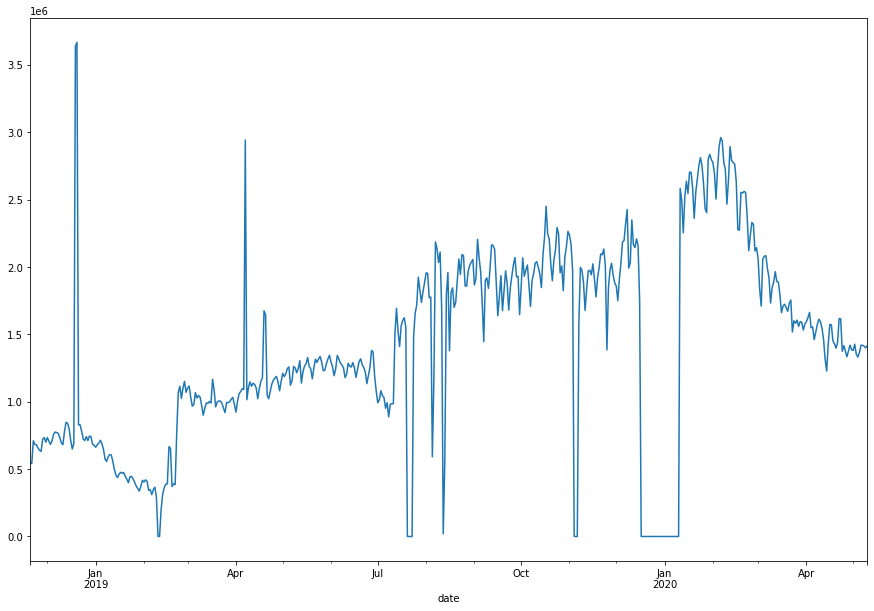

In [14]:
dat.total_wired.plot(figsize=(15, 10))

**detect frequencies / seasonality**

In [15]:
dat_ts = dat[values]

In [16]:
# Estimate power spectral density using a periodogram.
freq, spec = sc.signal.periodogram(dat_ts)

#freq, spec

In [17]:
freq_df = pd.DataFrame({'freq': freq, 
                        'spec': spec}) \
            .sort_values(by = 'spec', axis = 'index', ascending=False) \
            .head(10) \
            .assign(days = lambda x: (1/x['freq']).astype('int'))

seasonality candidates (days = 1 / freq)

check all possible days:

In [18]:
freq_df

,freq,spec,days
1,0.001859,8.016001e+13,538
3,0.005576,2.889832e+13,179
2,0.003717,1.398629e+13,269
8,0.014870,1.351850e+13,67
7,0.013011,1.262058e+13,76
5,0.009294,1.230235e+13,107
6,0.011152,1.115920e+13,89
4,0.007435,1.033722e+13,134
11,0.020446,7.975614e+12,48
9,0.016729,6.829338e+12,59


> In signal processing, a periodogram is an estimate of the spectral density of a signal.

The periodogram shows the “power” of each possible frequency, and we can clearly see spikes at around frequency 0.015 Hz (~66 days)

**get trend component**

which period to use?

In [19]:
idx = 0
p = freq_df['days'].iloc[idx]

In [20]:
# largest period/season
p

538

In [21]:
dat.shape

(538, 3)

want seasonality less than but closest to (RATIO * Dataframe size)         
freq_df shows some sort of **bi-monthly (~60 days)** periodicity

In [22]:
RATIO = 0.3

#while p > RATIO * dat.shape[0]:
while p > RATIO * 365:
    idx = idx + 1
    p = freq_df['days'].iloc[idx]

In [23]:
p

67

In [24]:
dat_ts

date
2018-11-20     541652
2018-11-21     541652
2018-11-22     710415
2018-11-23     682951
2018-11-24     680712
               ...   
2020-05-06    1419205
2020-05-07    1419223
2020-05-08    1412536
2020-05-09    1399905
2020-05-10    1415142
Freq: D, Name: total_wired, Length: 538, dtype: int64

In [25]:
result = seasonal_decompose(dat_ts, model = 'additive', period = p)

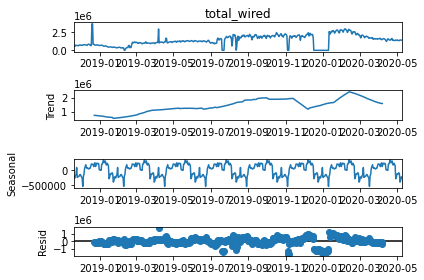

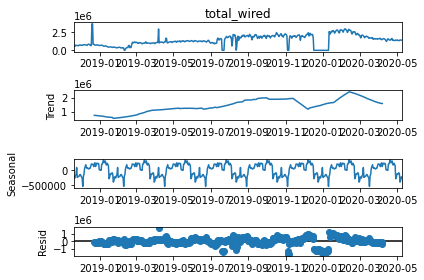

In [26]:
result.plot()

### Write back and fill gaps

In [27]:
result_df = pd.DataFrame({out_value_name : result.trend,
                          values : result.observed,
                          'Seasonal_discard' : result.seasonal,
                          'Residue_discard' : result.resid
                         }) \
            .reset_index()

In [28]:
result_df

,date,total_wired_clean,total_wired,Seasonal_discard,Residue_discard
0,2018-11-20,NaN,541652.0,-238427.628222,NaN
1,2018-11-21,NaN,541652.0,-262835.220973,NaN
2,2018-11-22,NaN,710415.0,-185274.719907,NaN
3,2018-11-23,NaN,682951.0,-149930.794533,NaN
4,2018-11-24,NaN,680712.0,73811.412290,NaN
...,...,...,...,...,...
533,2020-05-06,NaN,1419205.0,-394338.372359,NaN
534,2020-05-07,NaN,1419223.0,-348793.242295,NaN
535,2020-05-08,NaN,1412536.0,-224887.730568,NaN
536,2020-05-09,NaN,1399905.0,-238427.628222,NaN


**write data to disk**

In [29]:
result_df.to_csv(os.path.join(datapath, fname_out), index = False)